## Reproductible fitting

In [1]:
from typing import Any, cast

import matplotlib.pyplot as plt
import pandas as pd
import torch

import jmstate
from jmstate import (
    HazardFns,
    LogParamsHistory,
    ModelData,
    ModelDesign,
    ModelParams,
    MultiStateJointModel,
    RandomFit,
    SampleData,
    ValueStop,
    repr_from_cov,
)

In [2]:
torch.manual_seed(0)  # type: ignore


def tanh(t: torch.Tensor, psi: torch.Tensor):
    scale, offset, slope = psi.chunk(3, dim=-1)
    return (scale * torch.tanh((t - offset) / slope)).unsqueeze(-1)


def f(gamma: torch.Tensor | None, x: torch.Tensor | None, b: torch.Tensor):
    psi = cast(torch.Tensor, gamma) + torch.cat(
        [b, torch.zeros(*b.shape[:-1], 1)], dim=-1
    )
    psi[..., 2].exp_()
    return psi


def random_far_apart(
    n: int, m: int, a: torch.Tensor, b: torch.Tensor, min_dist: torch.Tensor
):
    L_free = (b - a) - (m - 1) * min_dist

    y = torch.rand(n, m) * L_free
    y, _ = torch.sort(y, dim=1)

    gap_offset = torch.arange(m) * min_dist

    return a + y + gap_offset

In [3]:
def plot_history(
    vals: list[torch.Tensor], true_val: torch.Tensor, name: str, colors: list[Any]
):
    plt.plot(torch.cat(vals, dim=0))  # type: ignore

    for i, t in enumerate(true_val):
        plt.axhline(  # type: ignore
            y=t.item(),
            color=colors[i],
            linestyle="--",
            label=(
                f"True value of {name}" + (f"({i + 1})" if true_val.numel() > 1 else "")
            ),
        )

    plt.title(f"Stochastic optimization of the parameter {name}.")  # type: ignore
    plt.legend()  # type: ignore
    plt.xlabel("Iteration")  # type: ignore
    plt.ylabel("Value")  # type: ignore
    plt.tight_layout()


def param_names(params_dict: dict[Any, Any]) -> list[str]:
    names: list[str] = []

    def _rec(node: dict[Any, Any] | torch.Tensor, prefix: list[Any]):
        if isinstance(node, torch.Tensor):
            base_name = str(prefix[0]) + "".join(f"[{item}]" for item in prefix[1:])
            num_elements = node.numel()
            if num_elements <= 1:
                names.append(base_name)
            else:
                names.extend(f"{base_name}[{i + 1}]" for i in range(num_elements))
        else:
            for k, v in node.items():
                prefix.append(k)
                _rec(v, prefix)
                prefix.pop()

    _rec(params_dict, [])

    return names

In [4]:
lmda, k = 3.0, 2.0
weibull_fn = jmstate.functions.Weibull(k, lmda)

gamma = torch.tensor([2.0, 3.0, 0.3])

Q = torch.diag(torch.tensor([0.3, 0.1]))
R = torch.tensor([[0.3]])

alphas = {("alive", "dead"): torch.tensor([0.4])}
betas = {("alive", "dead"): torch.tensor([-0.9, 0.8, 0.2])}

real_params = ModelParams(
    gamma,
    repr_from_cov(Q, method="diag"),
    repr_from_cov(R, method="ball"),
    alphas,
    betas,
)

Q_dist = torch.distributions.MultivariateNormal(torch.zeros(real_params.Q_repr.dim), Q)
R_dist = torch.distributions.MultivariateNormal(torch.zeros(real_params.R_repr.dim), R)

In [5]:
model_design = ModelDesign(f, tanh, {("alive", "dead"): HazardFns(weibull_fn, tanh)})

In [6]:
real_model = MultiStateJointModel(model_design, real_params)
real_model.fit_ = True

In [7]:
n, m, p = 500, 15, 3


def gen_data(n: int, m: int, p: int):
    c = torch.rand(n, 1) * 2 + 4
    x = torch.randn(n, p)

    b = Q_dist.sample((n,))
    psi = f(gamma, x, b)

    a = torch.zeros((n, 1))
    t = random_far_apart(n, m, a, c, 0.7 * c / m)

    trajectories_init = [[(0.0, "alive")] for _ in range(n)]
    sample_data = SampleData(x, trajectories_init, psi)
    trajectories = real_model.sample_trajectories(sample_data, c)

    y = model_design.regression_fn(t, psi)
    y += R_dist.sample(y.shape[:2])

    return x, t, y, trajectories, c

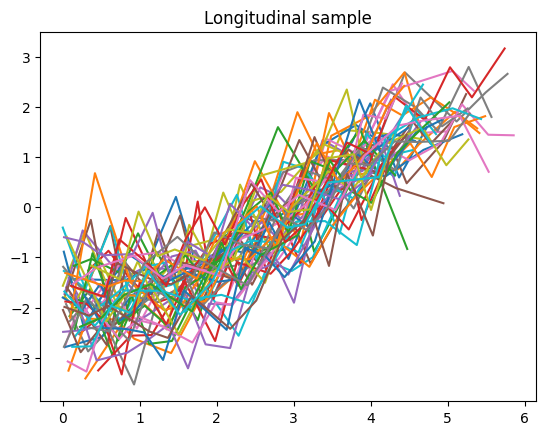

In [8]:
x, t, y, trajectories, c = gen_data(n, m, p)

plt.plot(t[:50].T, y[:50].squeeze(-1).T)  # type: ignore
plt.title("Longitudinal sample")  # type: ignore
plt.show()  # type: ignore

In [9]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    repr_from_cov(torch.eye(Q.size(0)), method="diag"),
    repr_from_cov(torch.eye(R.size(0)), method="ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

data = ModelData(x, t, y, trajectories, c)

In [ ]:
model = MultiStateJointModel(model_design, init_params)

metrics = model.do(
    data,
    job_factories=[
        jmstate.jobs.RandomFit(lr=0.1, amsgrad=True),
        LogParamsHistory(),
        ValueStop(),
    ],
    n_steps=50,
    max_iterations=300,
)

Running joint model:  87%|████████▋ | 260/300 [00:08<00:01, 29.92it/s]


In [11]:
def inv_sqrtm(A: torch.Tensor) -> torch.Tensor:
    eigvals, eigvecs = cast(tuple[torch.Tensor, ...], torch.linalg.eigh(A))  #  type: ignore
    return eigvecs @ torch.diag(eigvals.rsqrt()) @ eigvecs.T


def normalized_diff_sq(
    model: MultiStateJointModel, real_model: MultiStateJointModel
) -> torch.Tensor:
    normalized_diff = (
        model.params_.as_flat_tensor - real_model.params_.as_flat_tensor
    ) @ inv_sqrtm(FIM)
    return normalized_diff**2

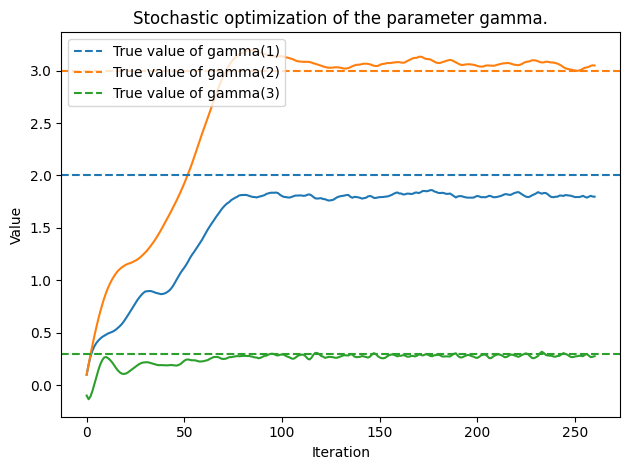

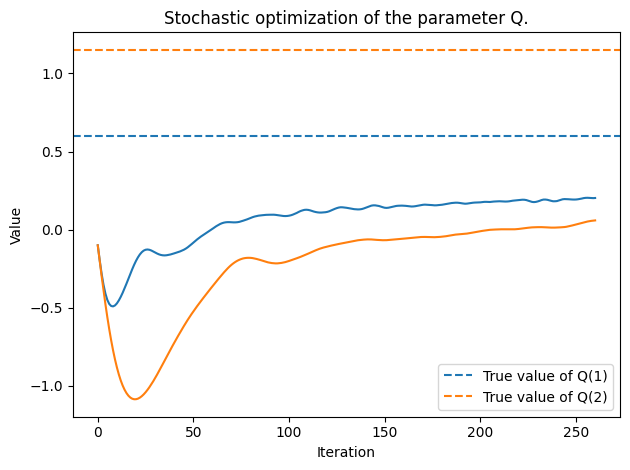

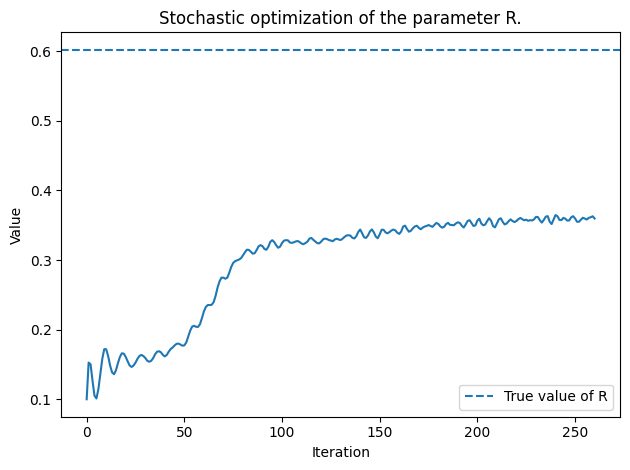

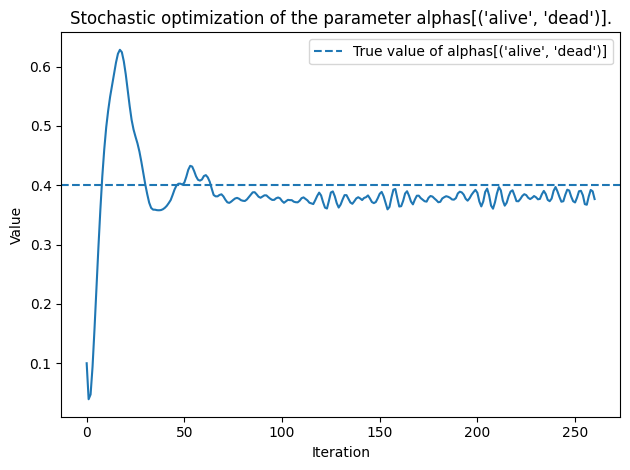

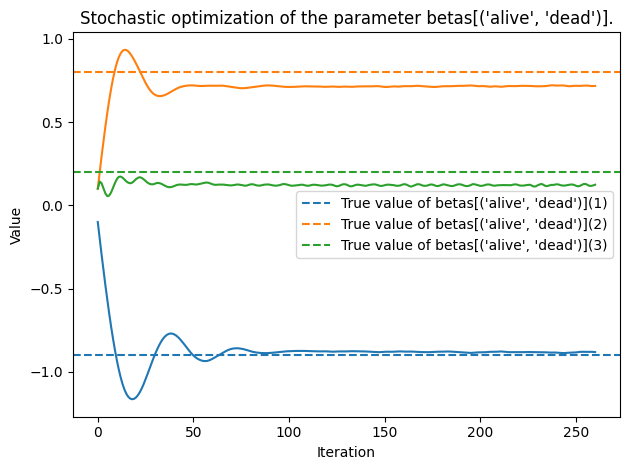

In [12]:
params_dict = model.params_.as_dict
real_params_dict = real_model.params_.as_dict
colors: list[Any] = cast(list[Any], plt.get_cmap("tab10").colors)  # type: ignore

for key, val in params_dict.items():
    if isinstance(val, torch.Tensor):
        history = [
            cast(torch.Tensor, p.as_dict[key])[None]
            for p in cast(list[ModelParams], metrics)
        ]
        plot_history(history, cast(torch.Tensor, real_params_dict[key]), key, colors)
        plt.savefig(f"figures/{key}.png")  # type: ignore
        plt.show()  # type: ignore
    else:
        for subkey in val:
            history = [p.as_dict[key][subkey][None] for p in metrics]
            plot_history(
                history, real_params_dict[key][subkey], key + f"[{subkey}]", colors
            )
            plt.savefig(f"figures/{key}_{subkey}.png")  # type: ignore
            plt.show()  # type: ignore

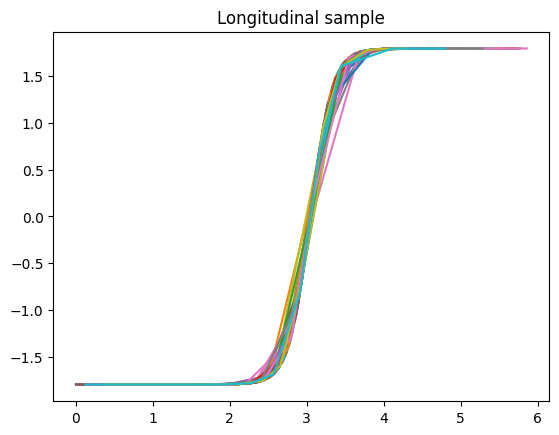

In [13]:
psi = model.params_.gamma.repeat(n, 1)


plt.plot(t[:50].T, model_design.regression_fn(t, psi)[:50].squeeze(-1).T)  # type: ignore
plt.title("Longitudinal sample")  # type: ignore
plt.show()  # type: ignore

In [14]:
normalized_diffs_sq: list[torch.Tensor] = []
n_runs = 10

for _ in range(n_runs):
    x, t, y, trajectories, c = gen_data(n, m, p)
    data = ModelData(x, t, y, trajectories, c)

    model = MultiStateJointModel(model_design, init_params)
    model.do(
        data,
        job_factories=[
            RandomFit(lr=0.1, amsgrad=True),
            ValueStop(),
        ],
        max_iterations=500,
    )

    normalized_diffs_sq.append(normalized_diff_sq(model, real_model))

Running joint model:  54%|█████▍    | 272/500 [00:07<00:06, 37.37it/s]


NameError: name 'FIM' is not defined

In [ ]:
names = param_names(real_model.params_.as_dict)

stacked_diffs = torch.stack(normalized_diffs_sq)

mean_diffs = stacked_diffs.mean(dim=0).sqrt()

data = {
    "Inverse FIM diag": (inv_sqrtm(FIM)).diag().numpy(),
    "Mean of Diffs": mean_diffs.numpy(),
}

index = [f"{names[i]}" for i in range(mean_diffs.size(0))]

df = pd.DataFrame(data, index=index)
pd.set_option("display.float_format", "{:.4e}".format)

print(df)

                             Inverse FIM diag  Mean of Diffs
gamma[1]                           4.7895e-01     5.4747e-02
gamma[2]                           7.8264e-01     1.0238e-01
gamma[3]                           4.5418e-01     2.4657e-02
Q[1]                               1.3296e+00     4.7022e-02
Q[2]                               9.6273e-01     4.7358e-02
Q[3]                               7.5369e-01     8.3525e-02
R                                  4.7074e-01     5.9931e-03
alphas[('alive', 'dead')]          2.0006e+00     4.6517e-02
betas[('alive', 'dead')][1]        9.3614e+00     5.2062e-01
betas[('alive', 'dead')][2]        8.8218e+00     3.9414e-01
betas[('alive', 'dead')][3]        8.2772e+00     3.1192e-01
